In [69]:
import pandas as pd          
import numpy as np          # For mathematical calculations
import matplotlib.pyplot as plt  # For plotting graphs
from datetime import datetime    # To access datetime
from pandas import Series        # To work on series
import matplotlib
import warnings                   # To ignore the warnings
warnings.filterwarnings("ignore")
from math import sqrt
from sklearn.metrics import mean_squared_error
from numpy import array
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats

In [70]:
df = pd.read_csv('PRSA_data.csv')

df = df.drop(['Ir','No','Is'],axis = 1)

#Changing the column names
cnames = list(df.columns)

#Drop the first row 
df = df[24:]

df.dtypes

df.reset_index(inplace = True)
df = df.drop(['index'], axis = 1)

df_new = df[['year', 'month', 'day', 'hour']]
df_new['date'] = pd.to_datetime(df_new)

df['date'] = df_new['date']

#Set the date as Index
df = df.set_index(df['date'],drop = False)
df = df.sort_index()

# df_cbwd = df['cbwd']
# df_cbwd['cbwd_mode'] = df_cbwd.resample("d").apply(lambda x: stats.mode(x)[0])

# df = df.resample('d').mean()
# df['cbwd'] = df_cbwd['cbwd_mode']

df['day_of_week'] = df.index.dayofweek

def weekend(row):
    if (row == 5) or (row == 6):
        return 1
    else:
        return 0

df['weekend'] = df['day_of_week'].apply(weekend)


mean = df['pm2.5'].min()
std_dev = df['pm2.5'].max() - df['pm2.5'].min()

for field in cnames:
    print(field, df[field].isna().sum())

df['pm2.5'] = df['pm2.5'].fillna(df['pm2.5'].mean())

df = pd.get_dummies(df, columns = ['cbwd'] )    

df['PM2.5'] = df['pm2.5']
df = df.drop(['pm2.5'], axis = 1)

df = df.drop(['hour', 'date'], axis = 1)

cnames = list(df.columns)

year 0
month 0
day 0
hour 0
pm2.5 2043
DEWP 0
TEMP 0
PRES 0
cbwd 0
Iws 0


In [71]:
df.head()

,year,month,day,DEWP,TEMP,PRES,Iws,day_of_week,weekend,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv,PM2.5
date,,,,,,,,,,,,,,
2010-01-02 00:00:00,2010,1,2,-16,-4.0,1020.0,1.79,5,1,0,0,1,0,129.0
2010-01-02 01:00:00,2010,1,2,-15,-4.0,1020.0,2.68,5,1,0,0,1,0,148.0
2010-01-02 02:00:00,2010,1,2,-11,-5.0,1021.0,3.57,5,1,0,0,1,0,159.0
2010-01-02 03:00:00,2010,1,2,-7,-5.0,1022.0,5.36,5,1,0,0,1,0,181.0
2010-01-02 04:00:00,2010,1,2,-7,-5.0,1022.0,6.25,5,1,0,0,1,0,138.0


In [72]:
df = df.resample('d').mean()

In [73]:
df.head()

,year,month,day,DEWP,TEMP,PRES,Iws,day_of_week,weekend,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv,PM2.5
date,,,,,,,,,,,,,,
2010-01-02,2010.0,1.0,2.0,-8.500000,-5.125000,1024.750000,24.860000,5.0,1.0,0.000,0.000000,1.00,0.000000,145.958333
2010-01-03,2010.0,1.0,3.0,-10.125000,-8.541667,1022.791667,70.937917,6.0,1.0,0.000,0.166667,0.75,0.083333,78.833333
2010-01-04,2010.0,1.0,4.0,-20.875000,-11.500000,1029.291667,111.160833,0.0,0.0,0.000,1.000000,0.00,0.000000,31.333333
2010-01-05,2010.0,1.0,5.0,-24.583333,-14.458333,1033.625000,56.920000,1.0,0.0,0.375,0.583333,0.00,0.041667,42.458333
2010-01-06,2010.0,1.0,6.0,-23.708333,-12.541667,1033.750000,18.511667,2.0,0.0,0.500,0.416667,0.00,0.083333,56.416667


In [74]:
df = df.iloc[:-2,:]

In [78]:
for field in cnames:
	df[field] = (df[field] - df[field].min())/(df[field].max() - df[field].min())

In [79]:
train_x = df['PM2.5'][:-4]
test_x = df['PM2.5'][-4:]
train_x.head()

date
2010-01-02    0.269502
2010-01-03    0.142996
2010-01-04    0.053476
2010-01-05    0.074443
2010-01-06    0.100749
Freq: D, Name: PM2.5, dtype: float64

In [80]:
train_cps_log = train_x.values

test_cps_log = test_x.values
print(train_cps_log.shape, test_cps_log.shape)

(1819,) (4,)


In [81]:
!pip install pyramid-arima

In [82]:
from pyramid.arima import auto_arima

'''SARIMA Implementation on log model'''

stepwise_model_log = auto_arima(train_cps_log, start_p = 1, start_q = 1,
                            max_p = 2, max_q = 2, m = 12,
                            start_P = 0, seasonal = False,
                            d = 0, D = 1, trace = True,
                            error_action = 'ignore',
                            suppress_warnings = True,
                            stepwise_warnings = True,
                            stepwise = True)

print(stepwise_model_log.aic())

Fit ARIMA: order=(1, 0, 1); AIC=-2672.083, BIC=-2650.059, Fit time=0.285 seconds
Fit ARIMA: order=(0, 0, 0); AIC=-1937.648, BIC=-1926.636, Fit time=0.005 seconds
Fit ARIMA: order=(1, 0, 0); AIC=-2624.140, BIC=-2607.622, Fit time=0.039 seconds
Fit ARIMA: order=(0, 0, 1); AIC=-2594.190, BIC=-2577.672, Fit time=0.045 seconds
Fit ARIMA: order=(2, 0, 1); AIC=-2670.099, BIC=-2642.569, Fit time=0.337 seconds
Fit ARIMA: order=(1, 0, 2); AIC=-2670.092, BIC=-2642.561, Fit time=0.395 seconds
Fit ARIMA: order=(2, 0, 2); AIC=-2671.670, BIC=-2638.634, Fit time=0.895 seconds
Total fit time: 2.004 seconds
-2672.0828487679337


In [83]:
stepwise_model_log.fit(train_cps_log)
print('Done')

Done


In [84]:
future_forecast_log = stepwise_model_log.predict(n_periods = 4)

In [85]:
y_hat = (future_forecast_log*std_dev)+mean
y_test = (test_cps_log*std_dev)+mean

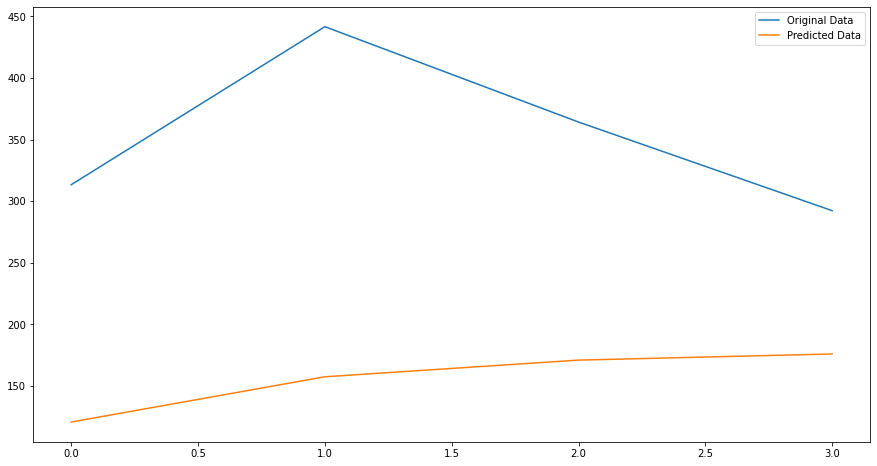

In [86]:
# future_forecast_antilog = np.exp(future_forecast_log)   #Converting log into normal values

#Visualisation of Predicted vs Original
plt.plot(y_test, label = 'Original Data')
plt.plot(y_hat, label = 'Predicted Data')
plt.legend()
plt.show()

In [87]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


rms_new = sqrt(mean_squared_error(y_test, y_hat))
print(rms_new)

mse_new = mean_squared_error(y_test, y_hat)
print(mse_new)

mae_new = mean_absolute_error(y_test, y_hat)
print(mae_new)

mape_new = mean_absolute_percentage_error(y_test, y_hat)
print(mape_new)

205.25818549391698
42130.92271225523
196.47148272402188
54.635909685173736
